<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Congressional_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyPDF2
!pip install dask

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.5 MB/s eta 0:00:00


In [2]:
import requests
from google.colab import output
import pprint
import os
from io import BytesIO
import PyPDF2
import re
import datetime
import dask

In [3]:
key = input('enter API key ')
os.environ['Congress_API_Key'] = key
output.clear()

In [4]:
def list_endpoints(year,month,day):
    date_today = datetime.datetime(year, month, day)
    endpoints = []
    for i in range(1, 365):
        past_date = date_today - datetime.timedelta(days=i)
        year = past_date.strftime("%Y")
        month = past_date.strftime("%m")
        day = past_date.strftime("%d")
        endpoint = f"https://api.congress.gov/v3/congressional-record/?y={year}&m={month}&d={day}&api_key={key}"
        endpoints.append(endpoint)
    return endpoints

In [5]:
def find_pdf_links(endpoints_list):
  try:
    links_to_pdfs_with_matches = []
    for i in endpoints_list:
        response = requests.get(i)
        if response.json()['Results']['Issues'] != []:
          link_to_pdf_file = response.json()['Results']['Issues'][0]['Links']['FullRecord']['PDF'][0]['Url']
          pdf_file = requests.get(link_to_pdf_file)
          if pdf_file.content[-7:] == b'\n%%EOF\n':
            pdf_data = BytesIO(pdf_file.content)
            pdf_reader = PyPDF2.PdfReader(pdf_data)
            number_of_pages = len(pdf_reader.pages)
            for j in range(number_of_pages):
              page = pdf_reader.pages[j]
              text = page.extract_text()
              adam_smith_matches = re.findall(r'Adam\sSmith\W*', text)
              if adam_smith_matches != []:
                print(link_to_pdf_file)
                links_to_pdfs_with_matches.append(link_to_pdf_file)
    return links_to_pdfs_with_matches
  except Exception as e:
    print(e)
    return links_to_pdfs_with_matches

delayed_pdf_links = [dask.delayed(find_pdf_links)(list_endpoints(i,5,28)) for i in range(1995,2025)]

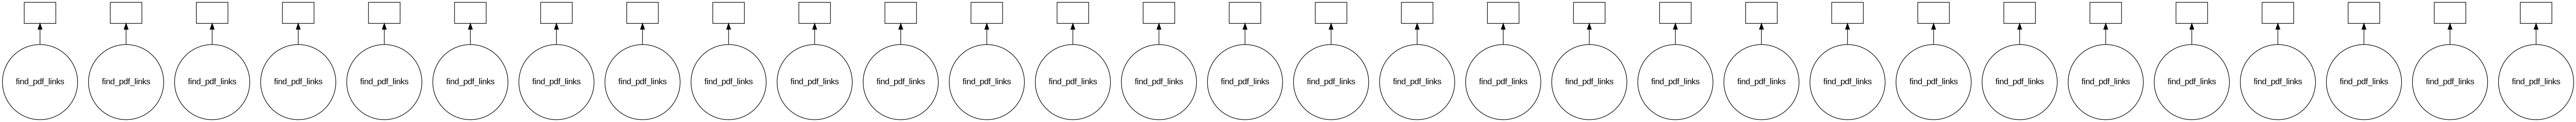

In [6]:
actual_pdf_links = dask.visualize(delayed_pdf_links)
display(actual_pdf_links)

In [7]:
actual_pdf_links = dask.compute(delayed_pdf_links)

https://www.congress.gov/107/crec/2002/05/23/CREC-2002-05-23.pdf
https://www.congress.gov/105/crec/1997/05/22/143/69/CREC-1997-05-22.pdf
Missed the stop code in LZWDecode!
https://www.congress.gov/104/crec/1995/05/23/141/86/CREC-1995-05-23.pdf
Missed the stop code in LZWDecode!
https://www.congress.gov/111/crec/2009/05/12/155/72/CREC-2009-05-12.pdf
https://www.congress.gov/111/crec/2009/05/06/CREC-2009-05-06.pdf
https://www.congress.gov/107/crec/2002/04/18/CREC-2002-04-18.pdf
https://www.congress.gov/111/crec/2009/05/04/CREC-2009-05-04.pdf
https://www.congress.gov/111/crec/2009/05/01/CREC-2009-05-01.pdf
https://www.congress.gov/111/crec/2009/04/30/CREC-2009-04-30.pdf
https://www.congress.gov/107/crec/2002/04/11/CREC-2002-04-11.pdf
https://www.congress.gov/107/crec/2002/04/09/CREC-2002-04-09.pdf
https://www.congress.gov/111/crec/2009/04/23/CREC-2009-04-23.pdf
https://www.congress.gov/107/crec/2002/03/20/CREC-2002-03-20.pdf
https://www.congress.gov/111/crec/2009/04/01/CREC-2009-04-01.pdf

https://www.congress.gov/108/crec/2003/02/07/CREC-2003-02-07.pdf


https://www.congress.gov/108/crec/2003/01/31/CREC-2003-01-31.pdf
https://www.congress.gov/108/crec/2003/01/30/CREC-2003-01-30.pdf
https://www.congress.gov/108/crec/2003/01/29/CREC-2003-01-29.pdf
https://www.congress.gov/108/crec/2003/01/29/CREC-2003-01-29.pdf


https://www.congress.gov/107/crec/2002/12/16/CREC-2002-12-16.pdf
https://www.congress.gov/107/crec/2002/11/22/CREC-2002-11-22.pdf


Expecting value: line 1 column 1 (char 0)


https://www.congress.gov/106/crec/2000/09/20/CREC-2000-09-20.pdf
https://www.congress.gov/112/crec/2012/05/17/CREC-2012-05-17.pdf
https://www.congress.gov/112/crec/2012/05/17/CREC-2012-05-17.pdf
https://www.congress.gov/106/crec/2000/09/14/CREC-2000-09-14.pdf
https://www.congress.gov/106/crec/2000/09/14/CREC-2000-09-14.pdf
https://www.congress.gov/106/crec/2000/09/08/CREC-2000-09-08.pdf


https://www.congress.gov/106/crec/2000/06/19/CREC-2000-06-19.pdf


https://www.congress.gov/106/crec/2000/06/15/146/75/CREC-2000-06-15.pdf
https://www.congress.gov/112/crec/2012/02/09/CREC-2012-02-09.pdf
https://www.congress.gov/112/crec/2012/02/06/CREC-2012-02-06.pdf
https://www.congress.gov/112/crec/2012/02/03/CREC-2012-02-03.pdf


https://www.congress.gov/106/crec/2000/06/08/146/70/CREC-2000-06-08.pdf
https://www.congress.gov/106/crec/2000/06/08/146/70/CREC-2000-06-08.pdf
https://www.congress.gov/112/crec/2011/12/13/CREC-2011-12-13.pdf
https://www.congress.gov/112/crec/2011/12/08/CREC-2011-12-08.pdf
https://www.congress.gov/118/crec/2023/04/19/169/65/CREC-2023-04-19.pdf
https://www.congress.gov/112/crec/2011/11/30/CREC-2011-11-30.pdf
https://www.congress.gov/118/crec/2023/04/06/169/60/CREC-2023-04-06.pdf
https://www.congress.gov/112/crec/2011/11/15/CREC-2011-11-15.pdf
https://www.congress.gov/118/crec/2023/03/09/169/45/CREC-2023-03-09.pdf
https://www.congress.gov/118/crec/2023/01/27/169/18/CREC-2023-01-27.pdf
https://www.congress.gov/118/crec/2023/01/27/169/18/CREC-2023-01-27.pdf
https://www.congress.gov/112/crec/2011/09/15/CREC-2011-09-15.pdf
https://www.congress.gov/112/crec/2011/08/16/CREC-2011-08-16.pdf
https://www.congress.gov/117/crec/2022/12/21/168/199/CREC-2022-12-21.pdf
https://www.congress.gov/112/crec

https://www.congress.gov/106/crec/2000/04/11/146/45/CREC-2000-04-11.pdf
https://www.congress.gov/106/crec/2000/03/21/146/32/CREC-2000-03-21.pdf
https://www.congress.gov/106/crec/2000/03/14/146/28/CREC-2000-03-14.pdf
https://www.congress.gov/106/crec/2000/03/14/146/28/CREC-2000-03-14.pdf
https://www.congress.gov/109/crec/2006/09/07/CREC-2006-09-07.pdf
https://www.congress.gov/106/crec/2000/02/10/146/12/CREC-2000-02-10.pdf
https://www.congress.gov/109/crec/2006/07/28/CREC-2006-07-28.pdf


https://www.congress.gov/106/crec/1999/11/17/145/163/CREC-1999-11-17.pdf
https://www.congress.gov/106/crec/1999/11/09/145/157/CREC-1999-11-09.pdf
https://www.congress.gov/106/crec/1999/11/09/145/157/CREC-1999-11-09.pdf
https://www.congress.gov/109/crec/2006/06/28/152/86/CREC-2006-06-28.pdf
https://www.congress.gov/109/crec/2006/06/22/152/82/CREC-2006-06-22.pdf
https://www.congress.gov/109/crec/2006/06/16/152/78/CREC-2006-06-16.pdf
https://www.congress.gov/106/crec/1999/11/02/145/152/CREC-1999-11-02.pdf
https://www.congress.gov/106/crec/1999/11/01/145/151/CREC-1999-11-01.pdf
https://www.congress.gov/106/crec/1999/10/28/145/149/CREC-1999-10-28.pdf
https://www.congress.gov/109/crec/2006/06/08/152/72/CREC-2006-06-08.pdf
https://www.congress.gov/106/crec/1999/10/27/145/148/CREC-1999-10-27.pdf
https://www.congress.gov/108/crec/2004/05/21/CREC-2004-05-21.pdf
https://www.congress.gov/108/crec/2004/05/19/CREC-2004-05-19.pdf
https://www.congress.gov/108/crec/2004/05/12/CREC-2004-05-12.pdf
https:

In [9]:
actual_pdf_links[0].sort()

In [10]:
actual_pdf_links[0]

[[],
 ['https://www.congress.gov/104/crec/1995/05/23/141/86/CREC-1995-05-23.pdf'],
 ['https://www.congress.gov/104/crec/1996/05/23/142/74/CREC-1996-05-23.pdf',
  'https://www.congress.gov/104/crec/1996/05/23/142/74/CREC-1996-05-23.pdf'],
 ['https://www.congress.gov/105/crec/1997/05/22/143/69/CREC-1997-05-22.pdf'],
 ['https://www.congress.gov/105/crec/1998/05/22/144/67/CREC-1998-05-22.pdf',
  'https://www.congress.gov/105/crec/1998/05/22/144/67/CREC-1998-05-22.pdf'],
 ['https://www.congress.gov/106/crec/2000/05/18/146/62/CREC-2000-05-18.pdf',
  'https://www.congress.gov/106/crec/2000/05/11/146/58/CREC-2000-05-11.pdf',
  'https://www.congress.gov/106/crec/2000/04/11/146/45/CREC-2000-04-11.pdf',
  'https://www.congress.gov/106/crec/2000/03/21/146/32/CREC-2000-03-21.pdf',
  'https://www.congress.gov/106/crec/2000/03/14/146/28/CREC-2000-03-14.pdf',
  'https://www.congress.gov/106/crec/2000/03/14/146/28/CREC-2000-03-14.pdf',
  'https://www.congress.gov/106/crec/2000/02/10/146/12/CREC-2000-02